In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
import pandas as pd
import numpy as np
## separando en train, test 
from sklearn.model_selection import train_test_split
## Configuración del RF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import random

- La tabla de métricas de tu mejor modelo
- La curva ROC
- La curva de precision y recall
- Las tablas de métricas obtenidas de la clase Group de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Group
- Las tablas de métricas obtenidas de la clase Bias de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Bias (disparidad)
- Las tablas de métricas obtenidas de la clase Fairness de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Fairness (equidad)

In [11]:
import pickle

In [12]:
y_test = pickle.load(
    open('/Users/ele/Documents/EquiposGit/Intro/Intropruebapipe/IntroCD_proy1/outputs/modeling/y_test.pkl','rb'))

In [13]:
# predicciones con el mejor predictor 
predicted_scores = pickle.load(
    open('/Users/ele/Documents/EquiposGit/Intro/Intropruebapipe/IntroCD_proy1/outputs/modeling/test_predict_scores.pkl','rb'))

In [27]:
dfx = pd.DataFrame(y_test)
dfx["1_prob"] = predicted_scores[:, 1]
dfx["prob_label"] = dfx["1_prob"].apply(lambda x: 1 if x >= 0.18 else 0)
dfx["correct"] = dfx.apply(lambda x: True if x["label"] == x["prob_label"] else False, axis=1)
dfx.head()

,label,1_prob,prob_label,correct
folio,,,,
C5/190613/06795,0.0,0.149512,0,True
C4/150322/02894,0.0,0.281806,1,False
C5/180302/01135,0.0,0.297361,1,False
C5/190411/07684,0.0,0.146666,0,True
C5/170212/06529,0.0,0.309855,1,False


In [28]:
predicted_labels= dfx['prob_label']
predicted_labels.head()

folio
C5/190613/06795    0
C4/150322/02894    1
C5/180302/01135    1
C5/190411/07684    0
C5/170212/06529    1
Name: prob_label, dtype: int64

In [29]:
predicted_labels.shape

(414942,)

In [30]:
predicted_scores.shape

(414942, 2)

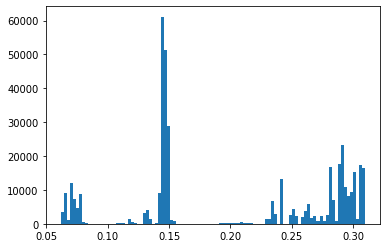

In [31]:
plt.hist(predicted_scores[:,1],bins=100)
plt.show()

## Métricas de desempeño

### ROC y AUC

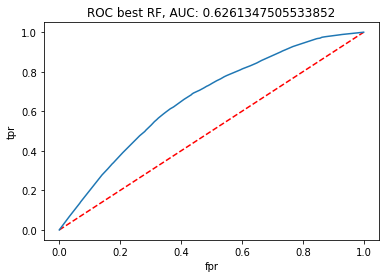

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

### Matriz de confusión

In [33]:
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
confu0=confusion_matrix(y_test, predicted_labels, normalize='all')
confu1=confusion_matrix(y_test, predicted_labels)

In [34]:
print(tabulate(np.array([['True Positive (tp)', 'False Negative (fn)'],
                    ['False Positive (fp)', 'True Negative (tn)']]),
               headers=['Dato\Predicción','Etiqueta +','Etiqueta -'],
               showindex=['Etiqueta +','Etiqueta -'],
               tablefmt='pretty'))

+-----------------+---------------------+---------------------+
| Dato\Predicción |     Etiqueta +      |     Etiqueta -      |
+-----------------+---------------------+---------------------+
|   Etiqueta +    | True Positive (tp)  | False Negative (fn) |
|   Etiqueta -    | False Positive (fp) | True Negative (tn)  |
+-----------------+---------------------+---------------------+


In [35]:
print(tabulate(confu1,
               headers=['Dato\Predicción','Etiqueta +','Etiqueta -'],
               showindex=['Etiqueta +','Etiqueta -'],
               tablefmt='pretty'))

+-----------------+------------+------------+
| Dato\Predicción | Etiqueta + | Etiqueta - |
+-----------------+------------+------------+
|   Etiqueta +    |   185059   |   145153   |
|   Etiqueta -    |   26110    |   58620    |
+-----------------+------------+------------+


In [36]:
print(tabulate(confu0,
               headers=['Dato\Predicción','Etiqueta +','Etiqueta -'],
               showindex=['Etiqueta +','Etiqueta -'],
               tablefmt='pretty'))

+-----------------+---------------------+--------------------+
| Dato\Predicción |     Etiqueta +      |     Etiqueta -     |
+-----------------+---------------------+--------------------+
|   Etiqueta +    | 0.4459876320064009  | 0.349815154889117  |
|   Etiqueta -    | 0.06292445691205036 | 0.1412727561924317 |
+-----------------+---------------------+--------------------+


#### Accuracy

$$accuracy=\frac{\text{tp+tn}}{\text{tp+fp+tn+fn}}= \frac{\text{predichos correctamente}}{\text{total}}$$

#### Precision


$$precision=\frac{\text{tp}}{\text{tp+fp}}= \frac{\text{predichos positivos correctos}}{\text{predichos positivos}}$$

De los que identificamos como clase positiva, cuántos identificamos correctamente -pureza en nuestra predicción-. 

### Recall

$$recall=\frac{\text{tp}}{\text{tp+fn}}= \frac{\text{predichos positivos correctos}}{\text{datos positivos}}$$

Del universo posible de nuestra clase positiva, cúantos identificamos correctamente

#### F1-score

Combina precision y recall para obtimizar ambos.

$$F=2\cdot  \left( \frac{\text{precision}\cdot \text{recall}}{\text{precision + recall}} \right)$$

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

In [38]:
#### Accuracy
accuracy_score(y_test, predicted_labels)

0.5872603881988326

In [39]:
#### Precision, recall, thresholds
precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [40]:
thresholds_2 = np.append(thresholds_2, 1)

In [41]:
(precision.shape, recall.shape, thresholds_2.shape)

((961,), (961,), (961,))

In [42]:
# F1_score junto con las otras medidas
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [43]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.061789,0.204230,1.000000,0.339187,1.000000,0.999800,0.000200,0.000000
1,0.062372,0.204316,0.999953,0.339303,0.999953,0.999225,0.000775,0.000047
2,0.062452,0.204323,0.999941,0.339313,0.999941,0.999167,0.000833,0.000059
3,0.062490,0.204425,0.999823,0.339447,0.999823,0.998422,0.001578,0.000177
4,0.062552,0.204458,0.999799,0.339490,0.999799,0.998198,0.001802,0.000201
...,...,...,...,...,...,...,...,...
935,0.303305,0.341528,0.142323,0.200918,0.142323,0.070409,0.929591,0.857677
936,0.305946,0.340072,0.135607,0.193896,0.135607,0.067523,0.932477,0.864393
937,0.306196,0.339078,0.128172,0.186026,0.128172,0.064104,0.935896,0.871828
938,0.308563,0.345293,0.066671,0.111762,0.066671,0.032437,0.967563,0.933329


In [44]:
negocio = metrics_report[metrics_report.fpr <= 0.07]
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
936,0.305946,0.340072,0.135607,0.193896,0.135607,0.067523,0.932477,0.864393
937,0.306196,0.339078,0.128172,0.186026,0.128172,0.064104,0.935896,0.871828
938,0.308563,0.345293,0.066671,0.111762,0.066671,0.032437,0.967563,0.933329
939,0.309855,0.345156,0.059377,0.101323,0.059377,0.028906,0.971094,0.940623


In [45]:
punto_corte = negocio.head(1).threshold.values[0]
punto_corte

0.30594641009653556

In [46]:
new_labels = [0 if score < punto_corte else 1 for score in predicted_scores[:,1]]

In [47]:
new_labels[:10]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

In [48]:
pd.Series(new_labels).sum()

33787

In [49]:
confusion_matrix(y_test, new_labels)

array([[307915,  22297],
       [ 73240,  11490]])

In [50]:
confusion_matrix(y_test, predicted_labels)

array([[185059, 145153],
       [ 26110,  58620]])

In [51]:
from sklearn.metrics import precision_score, recall_score

In [52]:
def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return precision_score(y_true, y_pred)

In [53]:
def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return recall_score(y_true, y_pred)

In [61]:
precision_at_k(predicted_labels,y_test,0.1)

0.6918446831110586

In [62]:
recall_at_k(predicted_labels,y_test,0.1)

0.28767304795041543

In [56]:
k_values = list(np.arange(0.1, 0.99, 0.01))

In [57]:
len(k_values)

89

In [58]:
d = pd.DataFrame(index=range(len(k_values)),columns=['k','precision','recall'])

In [59]:
for k in range(len(k_values)):
    d['k'][k] = k_values[k]
    d['precision'][k]=precision_at_k(predicted_labels,y_test,k_values[k])
    d['recall'][k]=recall_at_k(predicted_labels,y_test,k_values[k])

In [60]:
d

,k,precision,recall
0,0.1,0.691845,0.287673
1,0.11,0.691845,0.287673
2,0.12,0.691845,0.287673
3,0.13,0.691845,0.287673
4,0.14,0.691845,0.287673
...,...,...,...
84,0.94,0.491088,1
85,0.95,0.491088,1
86,0.96,0.491088,1
87,0.97,0.491088,1


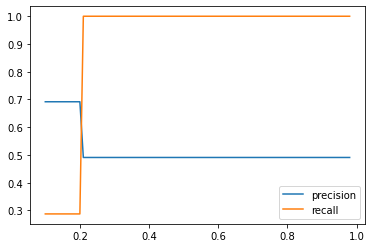

In [98]:
fig, ax1 = plt.subplots()
ax1.plot(d['k'], d['precision'], label='precision')
ax1.plot(d['k'], d['recall'], label='recall')
plt.legend()